In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import geopandas as gpd 
import requests
import json
import contextily as cx
import textwrap


In [4]:

top_stations = pd.read_csv('cleaned_data.csv', usecols=['start_station_name', 'start_lat', 'start_lng', 'member_casual'])
top_stations.rename(columns={'start_station_name': 'name', 'start_lat': 'lat', 'start_lng': 'lon'}, inplace=True)
top_stations.head(10)


,name,lat,lon,member_casual
0,Wabash Ave & Grand Ave,41.891466,-87.626761,member
1,DuSable Lake Shore Dr & Monroe St,41.880958,-87.616743,member
2,Clinton St & Madison St,41.882242,-87.641066,member
3,Clinton St & Madison St,41.882242,-87.641066,member
4,Clinton St & Madison St,41.882242,-87.641066,member
5,Carpenter St & Huron St,41.894556,-87.653449,member
6,Noble St & Milwaukee Ave,41.900680,-87.662600,member
7,Halsted St & Wrightwood Ave,41.929143,-87.649077,casual
8,Clinton St & Madison St,41.882242,-87.641066,member
9,Southport Ave & Waveland Ave,41.948067,-87.664012,member


In [6]:
top_stations = top_stations.sample(100000)
top_stations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 1790213 to 1353382
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   name           100000 non-null  object 
 1   lat            100000 non-null  float64
 2   lon            100000 non-null  float64
 3   member_casual  100000 non-null  object 
dtypes: float64(2), object(2)
memory usage: 3.8+ MB


In [7]:
# group by station and check for unique coordinates
groupy = top_stations.groupby('name')[['lat', 'lon']].nunique()
groupy.sort_values(by='lat', ascending=False).head(10)


,lat,lon
name,,
Streeter Dr & Grand Ave,379,396
Kingsbury St & Kinzie St,295,299
Wells St & Concord Ln,284,287
Clinton St & Washington Blvd,280,282
Wells St & Elm St,266,262
Clark St & Elm St,258,261
Clinton St & Madison St,244,244
Michigan Ave & Oak St,231,233
DuSable Lake Shore Dr & Monroe St,229,204


In [8]:
# find top 10 stations by count
top_group = top_stations.groupby('name')['name'].agg(Count='count').sort_values(by='Count', ascending=False).head(10).reset_index()
top_group

,name,Count
0,Streeter Dr & Grand Ave,1580
1,DuSable Lake Shore Dr & Monroe St,870
2,Michigan Ave & Oak St,827
3,DuSable Lake Shore Dr & North Blvd,790
4,Kingsbury St & Kinzie St,771
5,Clark St & Elm St,760
6,Wells St & Concord Ln,753
7,Millennium Park,738
8,Wells St & Elm St,680
9,Theater on the Lake,675


In [9]:

# Obtain station data from Divvy API
def jprint(obj):
    text = json.dumps(obj, sort_keys=True, indent=4)
    print(text)
bike = requests.get('https://gbfs.divvybikes.com/gbfs/en/station_information.json')
bike_json = bike.json()
bike_data = bike_json['data']['stations']
station = pd.DataFrame(bike_data)

# create dataframe with station name and coordinates
stations = station[['name', 'lat', 'lon']]
stations.head(10)

,name,lat,lon
0,Damen Ave & 59th St,41.785861,-87.674144
1,Wood St & Chicago Ave,41.895634,-87.672069
2,Wood St & Webster Ave,41.921057,-87.672797
3,Sedgwick St & Schiller St,41.907626,-87.638566
4,Wolcott Ave & Polk St,41.871262,-87.673688
5,Woodlawn Ave & Lake Park Ave,41.814093,-87.597005
6,MLK Jr Dr & 29th St,41.842052,-87.617000
7,Racine Ave & 65th St,41.775393,-87.654308
8,Halsted St & North Branch St,41.899390,-87.648545
9,Morgan St & 31st St,41.837800,-87.651140


In [10]:
# join top 10 stations dataframe with coordinate data from API
top_station = top_group.merge(stations, on='name', how='left')
top_station.head(10)

,name,Count,lat,lon
0,Streeter Dr & Grand Ave,1580,41.892278,-87.612043
1,DuSable Lake Shore Dr & Monroe St,870,41.880958,-87.616743
2,Michigan Ave & Oak St,827,41.900960,-87.623777
3,DuSable Lake Shore Dr & North Blvd,790,41.911722,-87.626804
4,Kingsbury St & Kinzie St,771,41.889177,-87.638506
5,Clark St & Elm St,760,41.902973,-87.631280
6,Wells St & Concord Ln,753,41.912133,-87.634656
7,Millennium Park,738,41.881032,-87.624084
8,Wells St & Elm St,680,41.903222,-87.634324
9,Theater on the Lake,675,41.926277,-87.630834


In [11]:
# create geodataframe from new top station dataframe
gdf = gpd.GeoDataFrame(top_station, geometry=gpd.points_from_xy(top_station.lon, top_station.lat), crs="EPSG:4326")
gdf.head(5)


,name,Count,lat,lon,geometry
0,Streeter Dr & Grand Ave,1580,41.892278,-87.612043,POINT (-87.61204 41.89228)
1,DuSable Lake Shore Dr & Monroe St,870,41.880958,-87.616743,POINT (-87.61674 41.88096)
2,Michigan Ave & Oak St,827,41.900960,-87.623777,POINT (-87.62378 41.90096)
3,DuSable Lake Shore Dr & North Blvd,790,41.911722,-87.626804,POINT (-87.62680 41.91172)
4,Kingsbury St & Kinzie St,771,41.889177,-87.638506,POINT (-87.63851 41.88918)


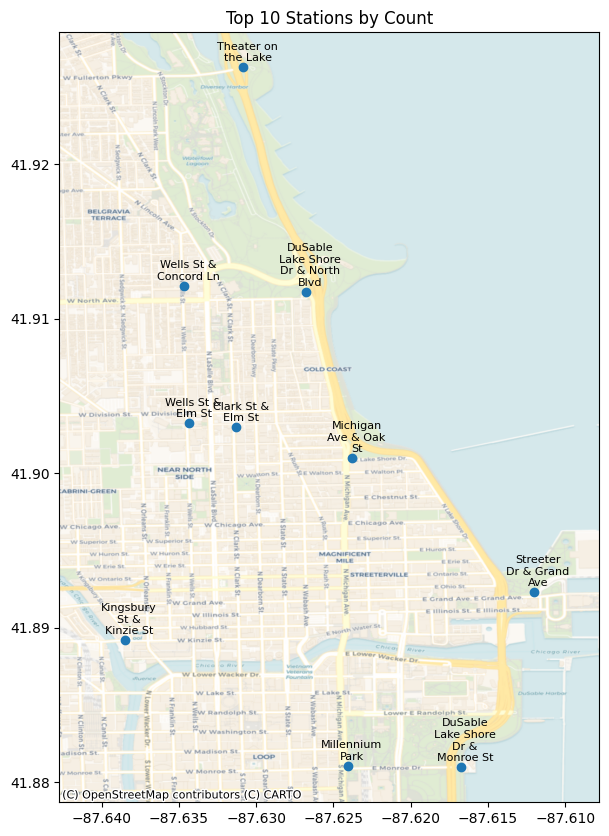

In [12]:
# plot top 10 stations on map
ax = gdf.plot(figsize=(10, 10))
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.Voyager)


for i, r in gdf.iterrows():
    wrapped_text = textwrap.fill(r['name'], width=10)
    ax.annotate(wrapped_text, xy=(r.geometry.x, r.geometry.y), xytext=(3, 3), textcoords="offset points", fontsize=8, ha='center', va='bottom')

buffer_ratio = 0.1
x_range = ax.get_xlim()[1] - ax.get_xlim()[0]
ax.set_xlim(ax.get_xlim()[0] - buffer_ratio * x_range, ax.get_xlim()[1] + buffer_ratio * x_range)
plt.title('Top 10 Stations by Count')
plt.show()

In [13]:
top_stations

,name,lat,lon,member_casual
1790213,Michigan Ave & Lake St,41.885431,-87.624683,casual
2532955,Halsted St & Wrightwood Ave,41.929152,-87.649112,casual
2757721,Clinton St & Roosevelt Rd,41.867118,-87.641088,member
1429576,Lincoln Ave & Diversey Pkwy,41.932225,-87.658617,member
4001820,Clifton Ave & Armitage Ave,41.918216,-87.656936,casual
...,...,...,...,...
1861866,Sheffield Ave & Webster Ave,41.921540,-87.653818,casual
1311245,Hermitage Ave & Polk St,41.871514,-87.669886,member
3200667,University Ave & 57th St,41.791458,-87.599871,member
3604440,Sedgwick St & Webster Ave,41.922167,-87.638888,member


In [18]:
# top 10 stations
x = top_stations.groupby('name').size().sort_values(ascending=False).head(10)
x

name
Streeter Dr & Grand Ave               1580
DuSable Lake Shore Dr & Monroe St      870
Michigan Ave & Oak St                  827
DuSable Lake Shore Dr & North Blvd     790
Kingsbury St & Kinzie St               771
Clark St & Elm St                      760
Wells St & Concord Ln                  753
Millennium Park                        738
Wells St & Elm St                      680
Theater on the Lake                    675
dtype: int64

In [19]:
ab = []
for l in x.index:
    ab.append(l)
    
print(ab)

['Streeter Dr & Grand Ave', 'DuSable Lake Shore Dr & Monroe St', 'Michigan Ave & Oak St', 'DuSable Lake Shore Dr & North Blvd', 'Kingsbury St & Kinzie St', 'Clark St & Elm St', 'Wells St & Concord Ln', 'Millennium Park', 'Wells St & Elm St', 'Theater on the Lake']


In [20]:
# filter out non top 10 stations
plot_data = top_stations[top_stations['name'].isin(ab)]

TypeError: 'Axes' object is not subscriptable

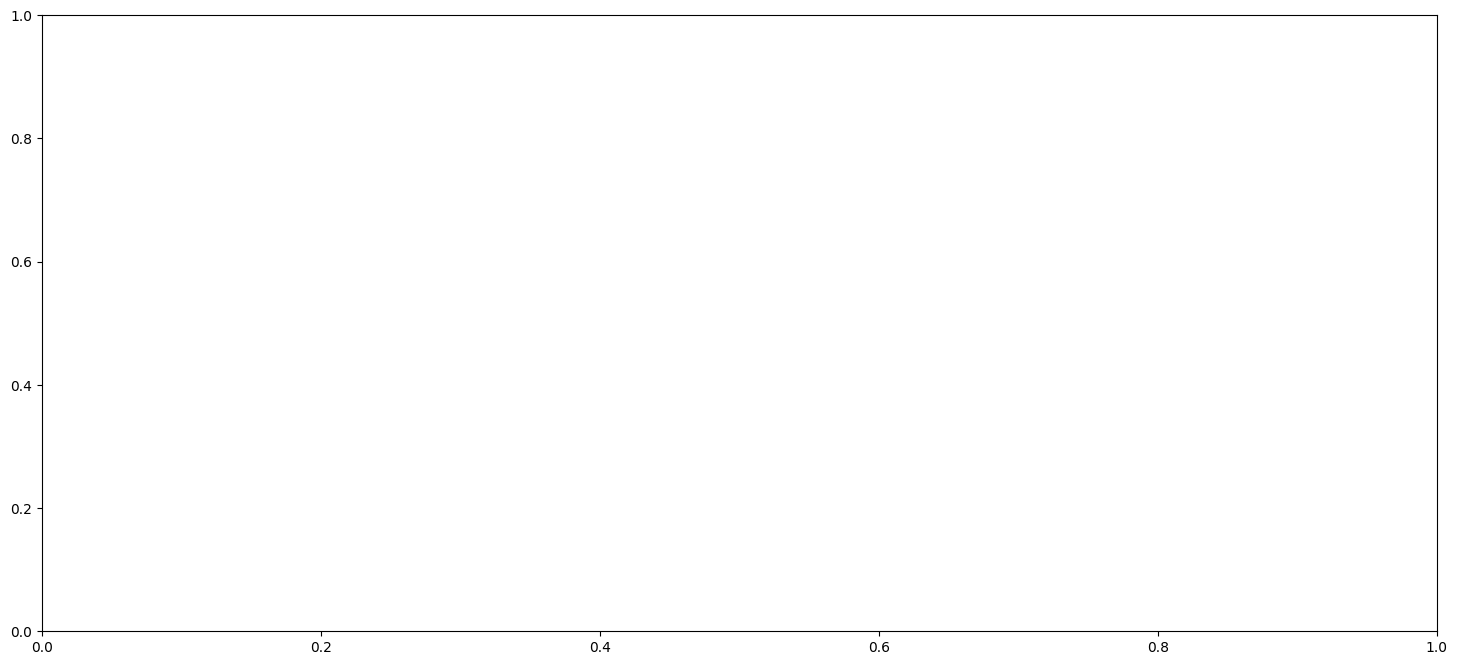

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt



# Define the color palettes you want to use
custom_palette2 = ['#FFC300', '#DAF7A6', '#FF5733', '#C70039']
palettes = ['Paired']

# Create subplots for each color palette
fig, axes = plt.subplots(1, len(palettes), figsize=(18, 8), sharey=True)

# Iterate over each palette and create a barplot
for i, palette in enumerate(palettes):
    # Set the color palette for the current subplot
    sns.set_palette(palette)
    
    # Create the barplot
    sns.countplot(x=plot_data['name'], hue=plot_data['member_casual'], ax=axes[i])
    
    # Set the title for the subplot
    axes[i].set_title(f'Palette: {palette}')
    axes[i].set_xticklabels([])

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


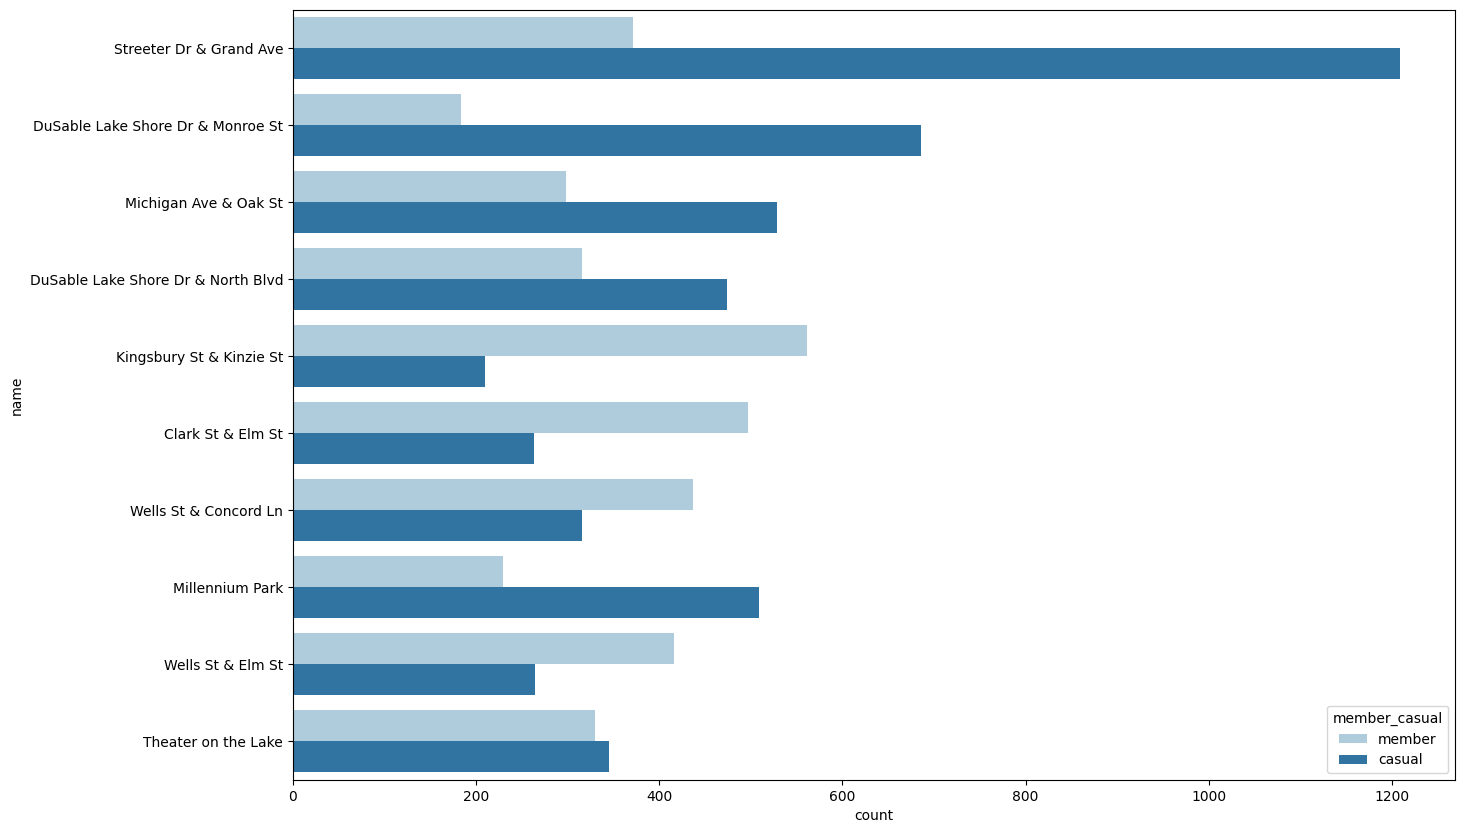

In [56]:

plt.figure(figsize=(15, 10))
sns.countplot(data=plot_data, y='name', hue='member_casual', order=ab, palette='Paired')
plt.show()

In [98]:
x = top_stations.groupby('name')['member_casual'].size().sort_values(ascending=False).head(10)


name
Streeter Dr & Grand Ave               15756
DuSable Lake Shore Dr & Monroe St      8652
Michigan Ave & Oak St                  8333
DuSable Lake Shore Dr & North Blvd     8281
Wells St & Concord Ln                  7796
Clark St & Elm St                      7363
Millennium Park                        7336
Kingsbury St & Kinzie St               7295
Theater on the Lake                    6966
Wells St & Elm St                      6578
Name: member_casual, dtype: int64


In [68]:
top_stations.set_index(['name', 'member_casual'], inplace=True)
g = top_stations.groupby(level=[0,1]).size()
g

KeyError: "None of ['name', 'member_casual'] are in the columns"

In [66]:
df1 = top_stations.groupby(['name', 'member_casual']).size()
#df2 = df1.sort_values(by='count', ascending=False)
#df3 = df2.groupby('name').head(2)
df1


name                          member_casual
111th St - Morgan Park Metra  casual             1
                              member             1
2112 W Peterson Ave           casual            71
                              member           109
410                           casual             1
                                              ... 
Yates Blvd & 75th St          casual            33
                              member            16
Yates Blvd & 93rd St          casual            10
                              member            13
Yates Blvd & Exchange Ave     casual             3
Length: 2417, dtype: int64

In [64]:
df1 = top_stations.groupby(['name', 'member_casual']).[['name', 'member_casual']]size().reset_index(name='count')
df2 = df1.sort_values(by='count', ascending=False)
#df3 = df2.groupby('name').head(2)
df2


SyntaxError: invalid syntax (2207428325.py, line 1)

KeyError: 'member_casual'

In [38]:
top_members = top_stations.groupby(['name', 'member_casual'])['member_casual'].agg(count='count').sort_values(by='count', ascending=False).reset_index().head(10)
top_members

,name,member_casual,count
0,Streeter Dr & Grand Ave,casual,12019
1,DuSable Lake Shore Dr & Monroe St,casual,6682
2,Millennium Park,casual,5370
3,Kingsbury St & Kinzie St,member,5343
4,Michigan Ave & Oak St,casual,5284
5,DuSable Lake Shore Dr & North Blvd,casual,4846
6,Clark St & Elm St,member,4748
7,Clinton St & Washington Blvd,member,4491
8,Wells St & Concord Ln,member,4460
9,Shedd Aquarium,casual,4378


In [ ]:
sns.barplot(data=top_stations, x)

In [ ]:
for i, r in gdf.iterrows():
    ax.annotate(r['name'], xy=(r.geometry.x, r.geometry.y))

In [ ]:
ax2.table(cellText=df[['Station Name', 'Count']].values, colLabels=['Station Name', 'Count'], loc='center')


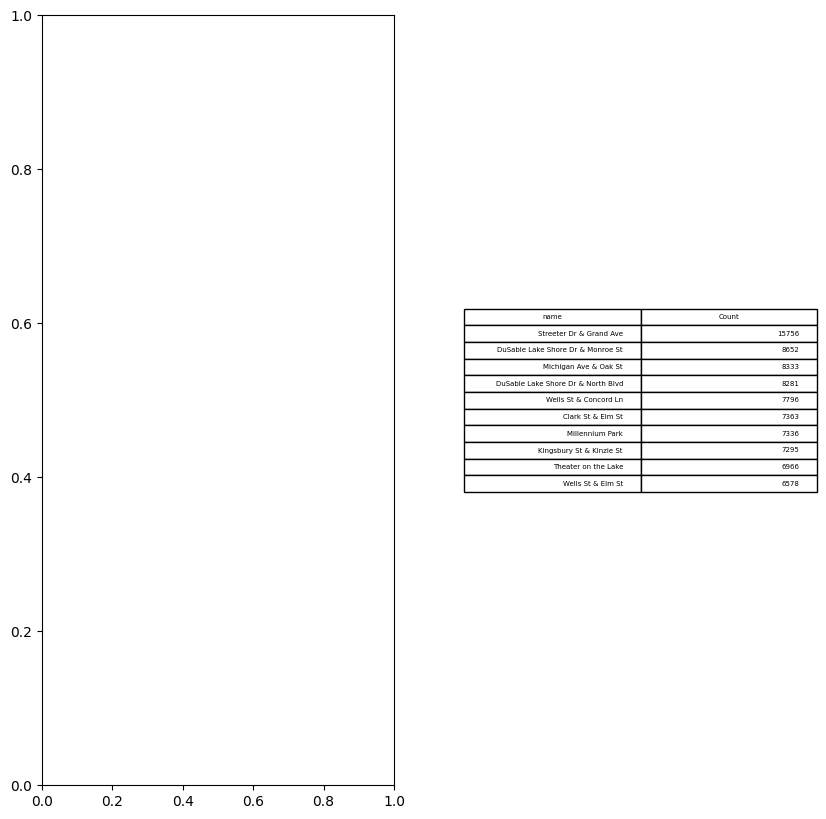

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

ax2.axis('off')
ax2.table(cellText=df2[['name', 'Count']].values, colLabels=['name', 'Count'], loc='center')


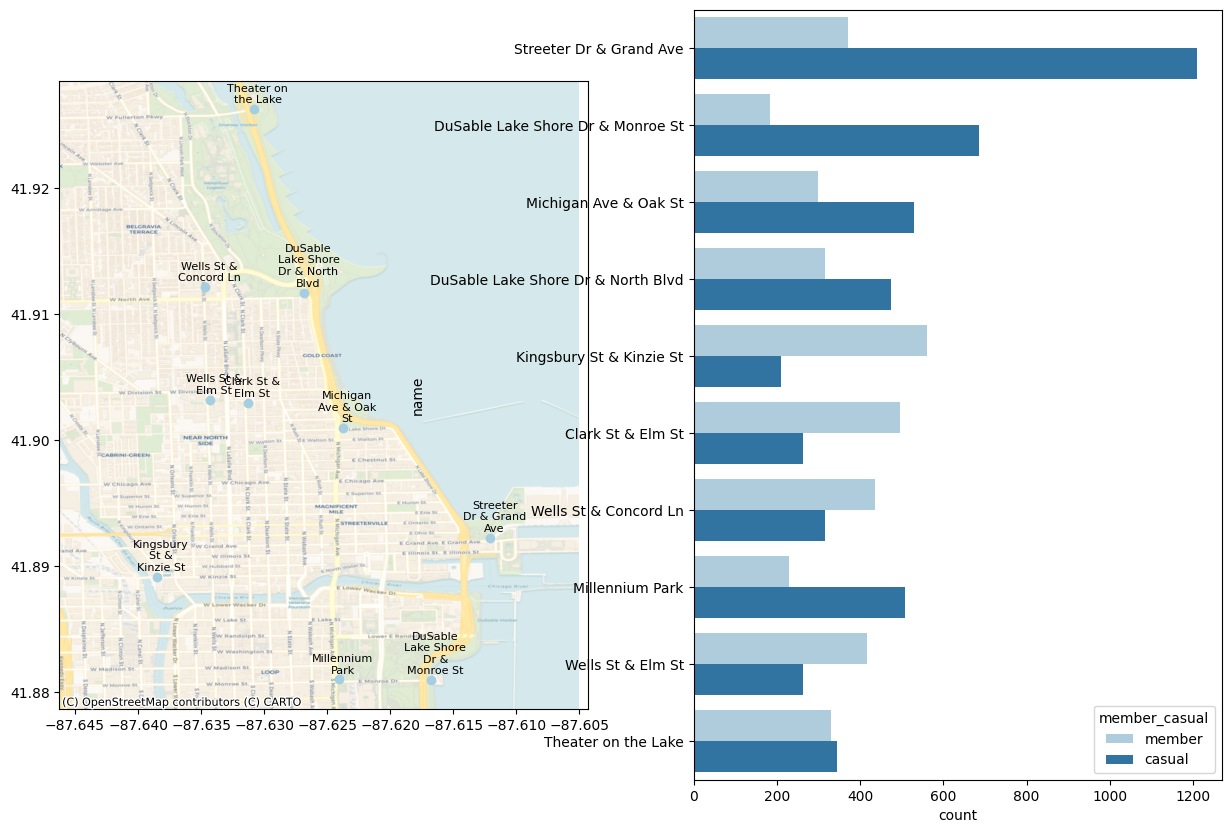

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
ax1 = gdf.plot(ax=axes[0])
cx.add_basemap(ax1, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.Voyager)


for i, r in gdf.iterrows():
    wrapped_text = textwrap.fill(r['name'], width=10)
    ax1.annotate(wrapped_text, xy=(r.geometry.x, r.geometry.y), xytext=(3, 3), textcoords="offset points", fontsize=8, ha='center', va='bottom')

buffer_ratio = 0.1
x_range = ax.get_xlim()[1] - ax.get_xlim()[0]
ax1.set_xlim(ax.get_xlim()[0] - buffer_ratio * x_range, ax.get_xlim()[1] + buffer_ratio * x_range)


sns.countplot(ax=axes[1], data=plot_data, y='name', hue='member_casual', order=ab, palette='Paired')


plt.show()

# one map, one side by side bar plot

In [ ]:
chicago = gpd.read_file(gds.get_path('geoda.chicago_health'))
chicago.head(5)

In [30]:
chicago.crs

<Geographic 2D CRS: GEOGCS["WGS84(DD)",DATUM["WGS_1984",SPHEROID["WGS8 ...>
Name: WGS84(DD)
Axis Info [ellipsoidal]:
- lon[east]: Longitude (Degree)
- lat[north]: Latitude (Degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS84
- Prime Meridian: Greenwich

In [40]:
chicago.crs

<Geographic 2D CRS: GEOGCS["WGS84(DD)",DATUM["WGS_1984",SPHEROID["WGS8 ...>
Name: WGS84(DD)
Axis Info [ellipsoidal]:
- lon[east]: Longitude (Degree)
- lat[north]: Latitude (Degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS84
- Prime Meridian: Greenwich

In [ ]:
chicago.centroid.explore()

In [37]:
ax = chicago.centroid.explore()
cx.add_basemap(ax, crs=chicago.crs.to_string())

C:\Users\Andy\AppData\Local\Temp\ipykernel_22432\1963832225.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ax = chicago.centroid.explore()


AttributeError: 'Map' object has no attribute 'axis'

In [ ]:
station_list.drop(['electric_bike_surcharge_waiver', 'has_kiosk', 'rental_uris', 'eightd_has_key_dispenser', 'eightd_station_services', 'target_bike_capacity', 'target_scooter_capacity', 'region_id', 'region_code', 'client_station_id', 'rack_model'], axis=1, inplace=True)